In [5]:
from google.colab import drive

# Mount Google Drive to access files stored there
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Install unrar tool for extracting .rar files
!apt-get install -y unrar

import os

base_path = "/content/drive/MyDrive/X-ray"

for split in ['train', 'val', 'test']:
    rar_path = os.path.join(base_path, f"{split}.rar")
    extract_path = os.path.join(base_path, split)
    os.makedirs(extract_path, exist_ok=True)
    !unrar x -o+ "{rar_path}" "{extract_path}/"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/X-ray/train.rar

Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP130.jpg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP130_aug_0.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP131.jpg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP131_aug_0.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP132.jpg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNormal/OP132_aug_0.jpeg       0%  OK 
Extracting  /content/drive/MyDrive/X-ray/train/train/AbNor

In [6]:
train_path = os.path.join(base_path, 'train', 'train')
val_path = os.path.join(base_path, 'val', 'val')
test_path = os.path.join(base_path, 'test', 'test')

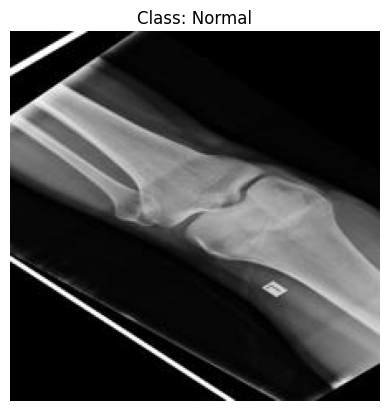

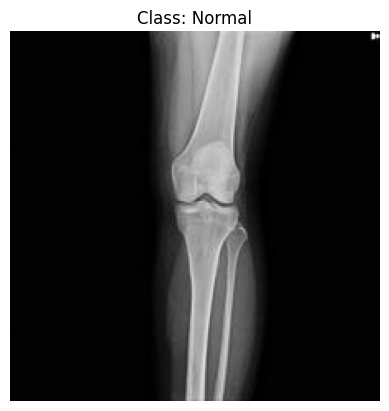

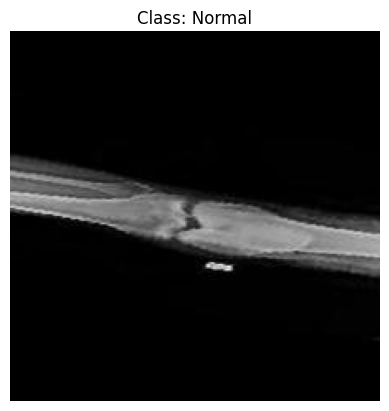

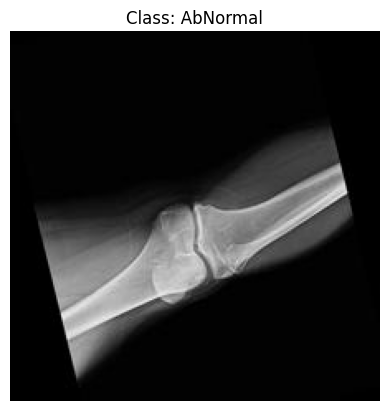

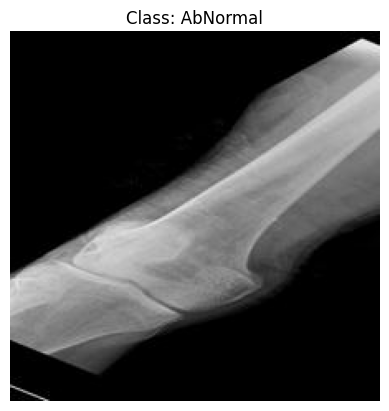

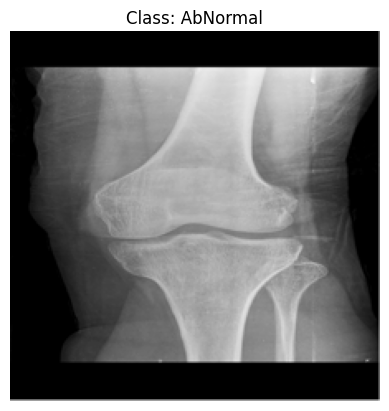

Class distribution in training set:
{'Normal': 1260, 'AbNormal': 2519}


In [7]:
from PIL import Image
import matplotlib.pyplot as plt

def show_sample_images(folder, num_samples=3):
    classes = os.listdir(folder)
    for cls in classes:
        imgs = os.listdir(os.path.join(folder, cls))[:num_samples]
        for img in imgs:
            img_path = os.path.join(folder, cls, img)
            im = Image.open(img_path)
            plt.imshow(im, cmap='gray')
            plt.title(f"Class: {cls}")
            plt.axis('off')
            plt.show()

def class_distribution(folder):
    dist = {}
    for cls in os.listdir(folder):
        dist[cls] = len(os.listdir(os.path.join(folder, cls)))
    return dist

show_sample_images(train_path)
print("Class distribution in training set:")
print(class_distribution(train_path))

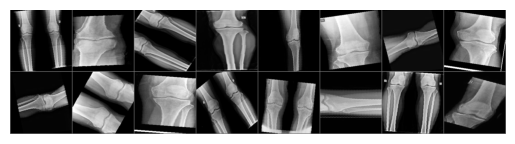

In [8]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch
import torchvision
import numpy as np

transform_pipeline = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])

train_dataset = ImageFolder(root=train_path, transform=transform_pipeline)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

def imshow(img):
    img = img * 0.25 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))

1.rotation

دلیل:

در عمل واقعی، بیمار یا دستگاه ممکن است کمی زاویه داشته باشد.

چرخش ملایم مدل را نسبت به چنین ناپایداری‌هایی مقاوم می‌کند.

بر ساختار آناتومیکی کلی تأثیر نمی‌گذارد.

چرا مناسب تصاویر اشعه ایکس:

ساختارهای مانند استخوان زانو یا قفسه سینه در چرخش‌های کوچک تغییر معنایی نمی‌کنند، پس مدل بهتر تعمیم می‌دهد.

2.Brightness/Contrast Adjustment

دلیل:

دستگاه‌های رادیولوژی مختلف یا شرایط محیطی متفاوت، تصاویر با شدت‌های نوری متفاوت تولید می‌کنند.

این تکنیک به مدل یاد می‌دهد که با شدت روشنایی متفاوت، ویژگی‌های معنادار را استخراج کند.

چرا مناسب:

ویژگی‌های تشخیصی (مانند تراکم استخوان یا لکه در ریه) باید تحت تغییر شدت قابل شناسایی باقی بمانند.

3.random resized crop

دلیل:

مدل را به بخش‌های مختلف تصویر حساس می‌کند.

از overfitting روی ویژگی‌های خاص تصویر جلوگیری می‌کند.

چرا مناسب:

در تصاویر اشعه ایکس اغلب نواحی خاصی (مثلاً وسط تصویر) درگیر بیماری هستند، این روش کمک می‌کند مدل وابستگی صرف به آن ناحیه نداشته باشد

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
from PIL import Image
import os

def extract_features_from_images(folder, image_size=(64, 64)):
    features = []
    labels = []
    for cls in os.listdir(folder):
        cls_path = os.path.join(folder, cls)
        for img_name in os.listdir(cls_path):
            try:
                img_path = os.path.join(cls_path, img_name)
                img = Image.open(img_path).convert('L')  # grayscale
                img = img.resize(image_size)
                img_np = np.array(img).flatten()  # convert to 1D vector
                features.append(img_np)
                labels.append(cls)
            except:
                continue
    return np.array(features), np.array(labels)

# Extract features from train and test sets
X_train, y_train = extract_features_from_images(train_path)
X_test, y_test = extract_features_from_images(test_path)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Apply PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_pca, y_train_enc)

y_pred_log = logreg.predict(X_test_pca)

print("Logistic Regression:")
print(classification_report(y_test_enc, y_pred_log, target_names=le.classes_))

In [ ]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_pca, y_train_enc)

y_pred_rf = rf.predict(X_test_pca)

print("Random Forest:")
print(classification_report(y_test_enc, y_pred_rf, target_names=le.classes_))

مدل Logistic Regression:الگوریتم خطی ساده و پایه‌ای برای طبقه‌بندی دودویی؛ سریع و قابل تفسیر؛ مناسب برای داده‌های کاهش‌یافته با PCA

مدل Random Forest:مقاوم به نویز و داده‌های نامتوازن؛ امکان مدلسازی روابط غیرخطی؛ بدون نیاز به نرمال‌سازی ویژگی‌ها

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 112, 112]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 56, 56]
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")
test_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.25])
])

test_dataset = ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("CNN Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))


In [ ]:
from torchvision import models

# Load the pretrained ResNet18 model
resnet = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept grayscale images (1 channel instead of 3)
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the final fully connected layer to output 2 classes (Normal and Abnormal)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# Move the model to the available device (GPU or CPU)
model = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Number of epochs for training
num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss

        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate training accuracy for the current batch
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print average loss and accuracy for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# Evaluation on the test dataset
model.eval()  # Set model to evaluation mode

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Get the predicted class with highest score
        _, preds = torch.max(outputs, 1)

        # Store predictions and true labels for metrics calculation
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Print detailed classification report including precision, recall, and F1-score
from sklearn.metrics import classification_report
print("Transfer Learning (ResNet18) Classification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
import pandas as pd

# Function to evaluate a PyTorch model on a given DataLoader and return key metrics and confusion matrix
def evaluate_torch_model(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    with torch.no_grad():  # Disable gradient calculation for inference
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get predicted class index
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    return precision, recall, accuracy, f1, cm

# Evaluate the Basic CNN model on the test set
# Make sure to use the trained BasicCNN model here
basic_cnn_model = BasicCNN().to(device)
# If you have saved the trained CNN model, load it before evaluation:
# basic_cnn_model.load_state_dict(torch.load('path_to_saved_cnn.pth'))
basic_cnn_model.eval()
cnn_precision, cnn_recall, cnn_accuracy, cnn_f1, cnn_cm = evaluate_torch_model(basic_cnn_model, test_loader, device)

# Evaluate the ResNet18 transfer learning model on the test set
# 'model' variable here is assumed to be the trained ResNet18 model
resnet_precision, resnet_recall, resnet_accuracy, resnet_f1, resnet_cm = evaluate_torch_model(model, test_loader, device)

# Evaluate Logistic Regression model
logreg_precision = precision_score(y_test_enc, y_pred_log, average='weighted')
logreg_recall = recall_score(y_test_enc, y_pred_log, average='weighted')
logreg_accuracy = accuracy_score(y_test_enc, y_pred_log)
logreg_f1 = f1_score(y_test_enc, y_pred_log, average='weighted')

# Evaluate Random Forest model
rf_precision = precision_score(y_test_enc, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test_enc, y_pred_rf, average='weighted')
rf_accuracy = accuracy_score(y_test_enc, y_pred_rf)
rf_f1 = f1_score(y_test_enc, y_pred_rf, average='weighted')

# Create a summary DataFrame to compare all models
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "Basic CNN", "ResNet18 Transfer Learning"],
    "Precision": [logreg_precision, rf_precision, cnn_precision, resnet_precision],
    "Recall": [logreg_recall, rf_recall, cnn_recall, resnet_recall],
    "Accuracy": [logreg_accuracy, rf_accuracy, cnn_accuracy, resnet_accuracy],
    "F1-Score": [logreg_f1, rf_f1, cnn_f1, resnet_f1]
})

print(results_df)

# Function to plot confusion matrix with heatmap
def plot_cm(cm, classes, title):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# Plot confusion matrices for all models
plot_cm(cnn_cm, test_dataset.classes, "Confusion Matrix - Basic CNN")
plot_cm(resnet_cm, test_dataset.classes, "Confusion Matrix - ResNet18")

cm_logreg = confusion_matrix(y_test_enc, y_pred_log)
cm_rf = confusion_matrix(y_test_enc, y_pred_rf)
plot_cm(cm_logreg, le.classes_, "Confusion Matrix - Logistic Regression")
plot_cm(cm_rf, le.classes_, "Confusion Matrix - Random Forest")


Early Stopping: متوقف کردن آموزش وقتی که دقت روی داده اعتبارسنجی بهبود پیدا نکند.

Regularization: اضافه کردن جریمه‌هایی مثل L2 (Weight Decay) برای محدود کردن پیچیدگی مدل.

Dropout: در مدل‌های عمیق، حذف تصادفی برخی نورون‌ها در هر epoch برای جلوگیری از وابستگی بیش از حد.

Data Augmentation: افزایش تنوع داده‌های آموزشی با چرخش، تغییر روشنایی و غیره
تاثیر:

استفاده از این روش‌ها باعث می‌شود مدل عمومی‌تر شود و روی داده‌های جدید (تست) بهتر عمل کند.

به خصوص در مجموعه داده‌های کوچک و نامتوازن، کمک می‌کند مدل به جای حفظ کردن داده‌ها، الگوهای کلی را یاد بگیرد.
اهمیت معیار F1-Score در این مسئله
مسئله شما یک طبقه‌بندی پزشکی است که در آن:

تعداد نمونه‌ها بین دو کلاس (Normal و Abnormal) نامتوازن است.

دقت (Accuracy) ممکن است گمراه‌کننده باشد چون اگر مدل فقط کلاس غالب را پیش‌بینی کند، دقت بالایی دارد ولی عملکرد ضعیفی در تشخیص بیماران دارد.

F1-Score تعادلی بین Precision (درصد پیش‌بینی‌های درست مثبت) و Recall (درصد نمونه‌های مثبت واقعی که درست شناسایی شده‌اند) است.

بنابراین:

F1-score معیار بهتری برای ارزیابی عملکرد مدل است که به هر دو نوع خطا (False Positive و False Negative) توجه می‌کند.

کمک می‌کند مدل ما عادلانه‌تر و قابل اعتمادتر باشد، خصوصاً در کاربردهای پزشکی که خطاهای تشخیصی می‌تواند پیامدهای جدی داشته باشد
چگونه اطمینان حاصل کنیم که مدل در تشخیص پزشکی عادلانه و قابل اعتماد است؟
ارزیابی مدل روی داده‌های جداگانه و نامتوازن و گزارش معیارهایی مثل Precision، Recall و F1-score.

استفاده از Cross-validation برای اطمینان از پایداری مدل.

تحلیل Confusion Matrix برای بررسی اشتباهات مدل.

بررسی تاثیر استراتژی‌های جلوگیری از بیش‌برازش.

در نهایت، انجام آزمون‌های تخصصی توسط کارشناسان پزشکی.

